In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl

width, height = 10, 5
mpl.rcParams['figure.figsize'] = [width, height]


In [2]:
from sklearn import svm
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import model_selection

from utility_fns import form_last_n_games
from utility_fns import make_train_val_test


In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier


In [4]:
basedir = os.path.dirname(os.getcwd())
data = os.path.join(basedir, 'data', 'derived', 'cleaned_matches.csv')
defense = os.path.join(basedir, 'data', 'derived', 'stats_categories', 'DEFENSE_stats.csv')
snaps = os.path.join(basedir, 'data', 'derived', 'stats_categories', 'SNAP_COUNTS_stats.csv')

cleaned_matches = pd.read_csv(data)
# defense_stats = pd.read_csv(defense, index_col=[0,1,2])
# snaps_stats = pd.read_csv(snaps, index_col=[0,1,2])

In [5]:
cleaned_matches.Date = pd.to_datetime(cleaned_matches.Date)
cleaned_matches.sort_values(by='Date', inplace=True, ascending=True)
cleaned_matches.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 26122 entries, 0 to 26121
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Day             26122 non-null  object        
 1   Date            26122 non-null  datetime64[ns]
 2   Home/Away       26122 non-null  object        
 3   Opponent        26122 non-null  object        
 4   Score           26122 non-null  object        
 5   W/L/T           26122 non-null  object        
 6   Overtime        948 non-null    object        
 7   Location        26122 non-null  object        
 8   Venue           26122 non-null  object        
 9   Attendance      26098 non-null  float64       
 10  Notes           1061 non-null   object        
 11  Opponent Code   26122 non-null  object        
 12  Team            26122 non-null  object        
 13  Team Code       26122 non-null  object        
 14  Team Score      25942 non-null  float64       
 15  Op

In [6]:
cleaned_matches['Pct Team Score'] = cleaned_matches['Team Score'] / \
    (cleaned_matches['Team Score'] + cleaned_matches['Opponent Score'])
cleaned_matches['Pct Opponent Score'] = cleaned_matches['Opponent Score'] / \
    (cleaned_matches['Team Score'] + cleaned_matches['Opponent Score'])


## Train to classify based on the last-n-games a team played

In [7]:
x_cols = [
    'Team Code',
    'Opponent Code',
    'Location'
]
lookup_x_cols = [
    'Team Score',
    'Opponent Score',
    'Pct Team Score',
    'Pct Opponent Score',
    'Location'
]
key_x_cols = [
    'Team Code',
    'Opponent Code'
]
y_cols = [
    'Class'
]

played_matches = cleaned_matches.dropna(
    axis=0, how='any', subset=x_cols + y_cols + lookup_x_cols).copy()

played_matches['Class'].where(
    played_matches['Class'] > 0, other=0, inplace=True)


played_matches.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 25914 entries, 0 to 26121
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Day                 25914 non-null  object        
 1   Date                25914 non-null  datetime64[ns]
 2   Home/Away           25914 non-null  object        
 3   Opponent            25914 non-null  object        
 4   Score               25914 non-null  object        
 5   W/L/T               25914 non-null  object        
 6   Overtime            948 non-null    object        
 7   Location            25914 non-null  object        
 8   Venue               25914 non-null  object        
 9   Attendance          25890 non-null  float64       
 10  Notes               1051 non-null   object        
 11  Opponent Code       25914 non-null  object        
 12  Team                25914 non-null  object        
 13  Team Code           25914 non-null  object    

In [8]:
last_n_matches, new_columns = form_last_n_games(
    played_matches, 5, lookup_x_cols, key_x_cols)

.................................................
 Done


In [9]:
X = pd.concat([last_n_matches[x_cols], last_n_matches[new_columns]], axis=1)
y = last_n_matches[y_cols]

numeric_columns = X.columns[X.columns.str.contains('Score')]
dummies_columns = X.columns[~X.columns.str.contains('Score')]
print(dummies_columns)
print(numeric_columns)

Index(['Team Code', 'Opponent Code', 'Location', 'Team Code_p_Location',
       'Opponent Code_p_Location', 'Team Code_pp_Location',
       'Opponent Code_pp_Location', 'Team Code_ppp_Location',
       'Opponent Code_ppp_Location', 'Team Code_pppp_Location',
       'Opponent Code_pppp_Location', 'Team Code_ppppp_Location',
       'Opponent Code_ppppp_Location'],
      dtype='object')
Index(['Team Code_p_Team Score', 'Opponent Code_p_Team Score',
       'Team Code_pp_Team Score', 'Opponent Code_pp_Team Score',
       'Team Code_ppp_Team Score', 'Opponent Code_ppp_Team Score',
       'Team Code_pppp_Team Score', 'Opponent Code_pppp_Team Score',
       'Team Code_ppppp_Team Score', 'Opponent Code_ppppp_Team Score',
       'Team Code_p_Opponent Score', 'Opponent Code_p_Opponent Score',
       'Team Code_pp_Opponent Score', 'Opponent Code_pp_Opponent Score',
       'Team Code_ppp_Opponent Score', 'Opponent Code_ppp_Opponent Score',
       'Team Code_pppp_Opponent Score', 'Opponent Code_pppp

In [10]:
X.head()

,Team Code,Opponent Code,Location,Team Code_p_Team Score,Opponent Code_p_Team Score,Team Code_pp_Team Score,Opponent Code_pp_Team Score,Team Code_ppp_Team Score,Opponent Code_ppp_Team Score,Team Code_pppp_Team Score,...,Team Code_p_Location,Opponent Code_p_Location,Team Code_pp_Location,Opponent Code_pp_Location,Team Code_ppp_Location,Opponent Code_ppp_Location,Team Code_pppp_Location,Opponent Code_pppp_Location,Team Code_ppppp_Location,Opponent Code_ppppp_Location
12,buf,cle,"Buffalo, NY",6.0,6.0,0.0,28.0,21.0,0.0,0.0,...,"Buffalo, NY","Buffalo, NY","Buffalo, NY","Cleveland, OH","Buffalo, NY","Cleveland, OH","Buffalo, NY","Buffalo, NY","Buffalo, NY","Buffalo, NY"
19,gb,chic,"Chicago, IL",16.0,16.0,3.0,3.0,3.0,3.0,6.0,...,"Chicago, IL","Chicago, IL","Chicago, IL","Chicago, IL","Chicago, IL","Chicago, IL","Green Bay, WI","Chicago, IL","Green Bay, WI","Chicago, IL"
23,min,chic,"Chicago, IL",3.0,3.0,6.0,3.0,7.0,16.0,0.0,...,"Chicago, IL","Chicago, IL","Green Bay, WI","Chicago, IL","Green Bay, WI","Chicago, IL","Chicago, IL","Chicago, IL","Chicago, IL","Chicago, IL"
25,chic,buf,"Chicago, IL",0.0,7.0,3.0,0.0,3.0,10.0,16.0,...,"Chicago, IL","Chicago, IL","Chicago, IL","Chicago, IL","Chicago, IL","Buffalo, NY","Chicago, IL","Buffalo, NY","Chicago, IL","Buffalo, NY"
24,buf,chic,"Chicago, IL",9.0,9.0,7.0,0.0,0.0,3.0,10.0,...,"Chicago, IL","Chicago, IL","Chicago, IL","Chicago, IL","Chicago, IL","Chicago, IL","Buffalo, NY","Chicago, IL","Buffalo, NY","Chicago, IL"


In [11]:
def dataset_transformer():
    return ColumnTransformer([('scaler', StandardScaler(), numeric_columns), ('one-hot', OneHotEncoder(handle_unknown='ignore'), dummies_columns)])

dataset_transformer().fit(X, y).transformers

[('scaler',
  StandardScaler(),
  Index(['Team Code_p_Team Score', 'Opponent Code_p_Team Score',
         'Team Code_pp_Team Score', 'Opponent Code_pp_Team Score',
         'Team Code_ppp_Team Score', 'Opponent Code_ppp_Team Score',
         'Team Code_pppp_Team Score', 'Opponent Code_pppp_Team Score',
         'Team Code_ppppp_Team Score', 'Opponent Code_ppppp_Team Score',
         'Team Code_p_Opponent Score', 'Opponent Code_p_Opponent Score',
         'Team Code_pp_Opponent Score', 'Opponent Code_pp_Opponent Score',
         'Team Code_ppp_Opponent Score', 'Opponent Code_ppp_Opponent Score',
         'Team Code_pppp_Opponent Score', 'Opponent Code_pppp_Opponent Score',
         'Team Code_ppppp_Opponent Score', 'Opponent Code_ppppp_Opponent Score',
         'Team Code_p_Pct Team Score', 'Opponent Code_p_Pct Team Score',
         'Team Code_pp_Pct Team Score', 'Opponent Code_pp_Pct Team Score',
         'Team Code_ppp_Pct Team Score', 'Opponent Code_ppp_Pct Team Score',
         'Tea

In [12]:
X.describe()

,Team Code_p_Team Score,Opponent Code_p_Team Score,Team Code_pp_Team Score,Opponent Code_pp_Team Score,Team Code_ppp_Team Score,Opponent Code_ppp_Team Score,Team Code_pppp_Team Score,Opponent Code_pppp_Team Score,Team Code_ppppp_Team Score,Opponent Code_ppppp_Team Score,...,Team Code_p_Pct Opponent Score,Opponent Code_p_Pct Opponent Score,Team Code_pp_Pct Opponent Score,Opponent Code_pp_Pct Opponent Score,Team Code_ppp_Pct Opponent Score,Opponent Code_ppp_Pct Opponent Score,Team Code_pppp_Pct Opponent Score,Opponent Code_pppp_Pct Opponent Score,Team Code_ppppp_Pct Opponent Score,Opponent Code_ppppp_Pct Opponent Score
count,25778.000000,25778.000000,25778.000000,25778.000000,25778.000000,25778.000000,25778.000000,25778.000000,25778.000000,25778.000000,...,25778.000000,25778.000000,25778.000000,25778.000000,25778.000000,25778.000000,25778.000000,25778.000000,25778.000000,25778.000000
mean,20.625107,20.520327,20.486810,20.644154,20.674645,20.441811,20.419195,20.685701,20.621732,20.473427,...,0.498744,0.500914,0.502107,0.497647,0.497084,0.502712,0.503303,0.496486,0.497757,0.501936
std,10.556309,10.545986,10.527367,10.582325,10.575580,10.530929,10.528366,10.576797,10.559674,10.552603,...,0.209992,0.209965,0.210238,0.210033,0.209733,0.210612,0.210089,0.210319,0.210526,0.210269
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,...,0.370370,0.375000,0.377049,0.370370,0.370370,0.377049,0.375000,0.370370,0.370370,0.375000
50%,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
75%,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,...,0.625000,0.629630,0.629630,0.624632,0.625000,0.629630,0.629630,0.625000,0.625000,0.629630
max,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
y.head()

,Class
12,1
19,0
23,0
25,1
24,0


In [14]:
X_train, X_val, X_test, y_train, y_val, y_test = make_train_val_test(
    X, y, test_pct=0.2, val_pct=0.2, random_state=0
)

# y_train = y_train.ravel()
# y_val = y_val.ravel()
# y_test = y_test.ravel()

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)


(15466, 53) (15466, 1)
(5156, 53) (5156, 1)
(5156, 53) (5156, 1)


Evaluating linear kernel for C=0.01


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


Evaluating linear kernel for C=0.31622776601683794


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


Evaluating linear kernel for C=10.0


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


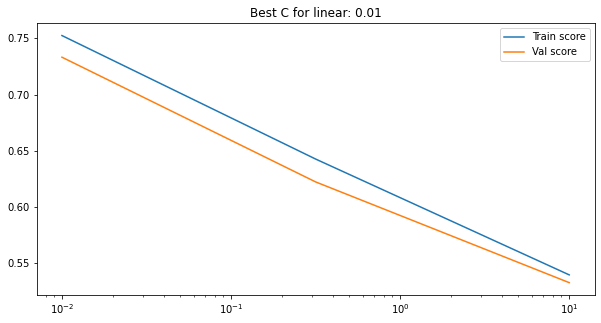

Evaluating poly kernel for C=0.01
Evaluating poly kernel for C=0.31622776601683794
Evaluating poly kernel for C=10.0


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


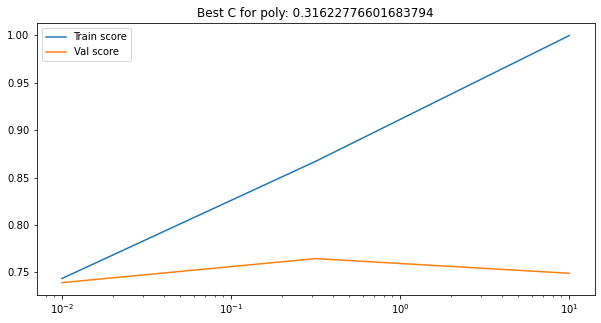

Evaluating rbf kernel for C=0.01
Evaluating rbf kernel for C=0.31622776601683794
Evaluating rbf kernel for C=10.0


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


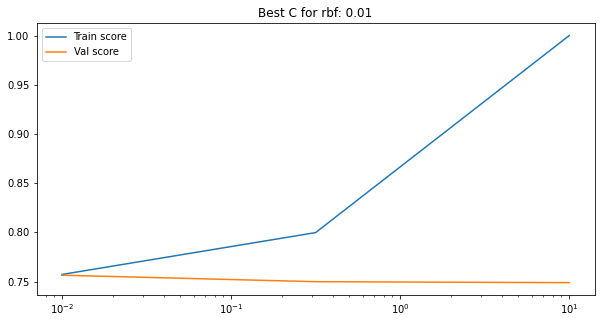

Evaluating sigmoid kernel for C=0.01
Evaluating sigmoid kernel for C=0.31622776601683794
Evaluating sigmoid kernel for C=10.0


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


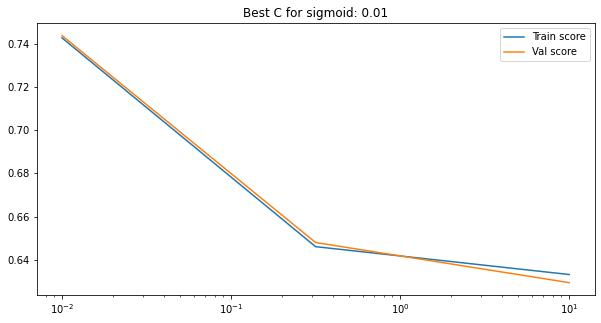

In [15]:
for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    train_scores = []
    val_scores = []
    val_space = np.geomspace(start=0.01, stop=10, num=3)
    for C in val_space:
        print(f"Evaluating {kernel} kernel for C={C}")
        model = make_pipeline(dataset_transformer(), svm.SVC(C=C, max_iter=10_000, kernel=kernel))

        model.fit(X_train, y_train.values.ravel())
        train_scores.append(model.score(X_train, y_train.values.ravel()))
        val_scores.append(model.score(X_val, y_val.values.ravel()))

    plt.title(f'Best C for {kernel}: {val_space[np.argmax(val_scores)]}')
    plt.plot(val_space, train_scores, label='Train score')
    plt.plot(val_space, val_scores, label='Val score')
    # plt.ylim(0, 1.1)
    plt.xscale('log')
    plt.legend()
    plt.show()


In [16]:
y_pred = model.predict(X_test)
precision, recall, fbeta_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

In [17]:
best_config = []
best_score = 0
best_fit_config = []
best_fit_score = 0
for estimator in [DecisionTreeClassifier(max_leaf_nodes=3), DecisionTreeClassifier(max_leaf_nodes=5), DecisionTreeClassifier(max_leaf_nodes=10), DecisionTreeClassifier(max_leaf_nodes=50)]:
  for nestimators in [10, 31, 62, 93, 124, 200, 300]:
    for nsamples in [10, 20, 30, 50, 75, 100]:
      clf = make_pipeline(dataset_transformer(), BaggingClassifier(base_estimator=estimator, n_estimators=nestimators, max_samples=nsamples))
      clf.fit(X_train, y_train.values.ravel())
      
      score = clf.score(X_val, y_val.values.ravel())
      if(score > best_score):
        best_config = [estimator, nestimators, nsamples]
        best_score = score
      
      score = clf.score(X_train, y_train)
      if(score > best_fit_score):
        best_fit_config = [estimator, nestimators, nsamples]
        best_fit_score = score
        
      print(end='.')

........................................................................................................................................................................

In [18]:
print(f"Best validation: {best_score}, {best_config}")
print(f"Best training: {best_fit_score}, {best_fit_config}")

Best validation: 0.7647401086113266, [DecisionTreeClassifier(max_leaf_nodes=50), 300, 100]
Best training: 0.7656795551532394, [DecisionTreeClassifier(max_leaf_nodes=50), 300, 100]


In [19]:
clf = make_pipeline(dataset_transformer(), DecisionTreeClassifier())
clf.fit(X_train, y_train)
clf.score(X_val, y_val)

0.7531031807602793

(array([[2526.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         2630.],
        [2630.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         2526.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 2 BarContainer objects>)

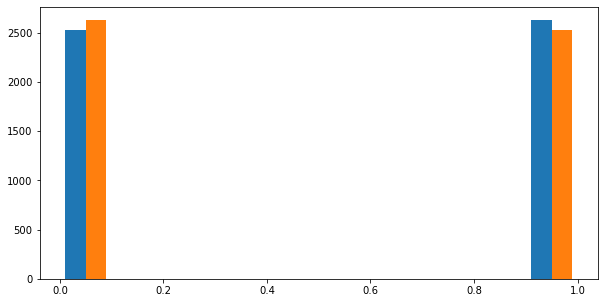

In [20]:
plt.hist(clf.predict_proba(X_test))

In [21]:
X_cv = pd.concat([X_train, X_val])
y_cv = pd.concat([y_train, y_val])

In [22]:
Cs = np.geomspace(0.01, 15, num=75)
scores = []
for c in Cs:
    model = make_pipeline(dataset_transformer(), svm.LinearSVC(dual=False, C=c, max_iter=100_000))
    scores.append(cross_val_score(
        model, X_cv, y_cv.values.ravel(), cv=5))
    print(end='.')


...........................................................................

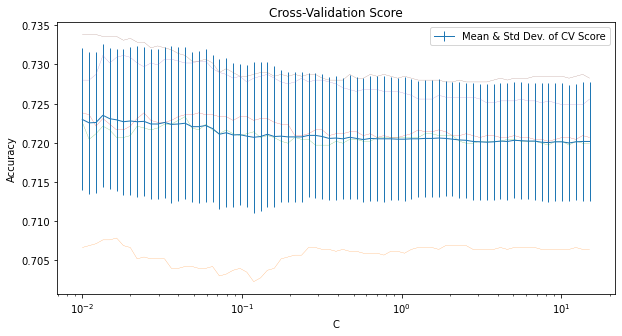

In [23]:
x = Cs
plt.errorbar(x, np.mean(scores,axis=1), np.std(scores,axis=1), label='Mean & Std Dev. of CV Score', linewidth=1)
plt.plot(x, np.sort(scores, axis=1), linewidth=0.2)
plt.legend()
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Score')
plt.show()

In [24]:
print('Maximum mean:', np.max(np.mean(scores,axis=1)))
print('Corresponding std deviation:', np.std(scores,axis=1)[np.argmax(np.mean(scores,axis=1))])
print('C:',Cs[np.argmax(np.mean(scores,axis=1))])

Maximum mean: 0.7234983158451636
Corresponding std deviation: 0.009122151868515147
C: 0.013451182233396298


In [25]:
print('Minimum std deviation:', np.min(np.std(scores,axis=1)))
print('Corresponding mean:', np.mean(scores,axis=1)[np.argmin(np.std(scores,axis=1))])
print('C:',Cs[np.argmin(np.std(scores,axis=1))])

Minimum std deviation: 0.007320006427824609
Corresponding mean: 0.7204435705258208
C: 2.078204189865019


In [26]:
best_mean_cs = np.flip(np.argsort(np.mean(scores,axis=1)))
best_std_cs = np.argsort(np.std(scores,axis=1))

In [27]:
# Do some random perturbation of the Cs
scores = []

Cs_to_examine = np.unique(np.concatenate(
    (Cs[best_mean_cs[:5]], Cs[best_std_cs[:5]])))
Cs_to_examine = np.unique(np.concatenate([Cs_to_examine, np.abs(Cs_to_examine + np.random.normal(scale=0.2,size=len(Cs_to_examine)))]))

for c in Cs_to_examine:
    model = make_pipeline(dataset_transformer(), svm.LinearSVC(dual=False, C=c, max_iter=100_000))
    
    scores.append(cross_val_score(
        model, X_cv, y_cv.values.ravel(), cv=100, n_jobs=-1))
    
    print(end='.')

....................

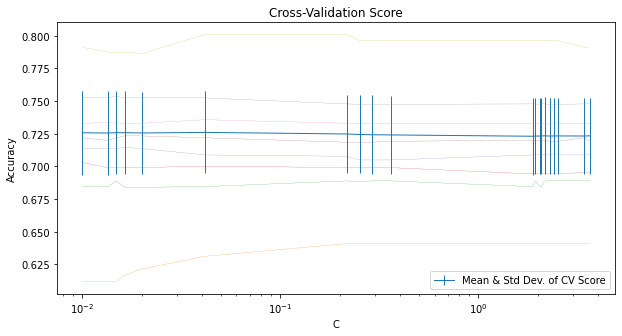

In [28]:
x = Cs_to_examine
quantiles = [0, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1.0]
plt.errorbar(x, np.mean(scores,axis=1), np.std(scores,axis=1), label='Mean & Std Dev. of CV Score', linewidth=1)
plt.plot(x, np.quantile(scores, quantiles, axis=1).T, linewidth=0.2)
plt.legend()
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Score')
plt.show()

In [29]:
best_mean_idx = np.argmax(np.mean(scores,axis=1))

print(f'Best C={Cs_to_examine[best_mean_idx]} with mean={np.mean(scores,axis=1)[best_mean_idx]}, std={np.std(scores,axis=1)[best_mean_idx]}')

Best C=0.04158646420719468 with mean=0.7260065193940245, std=0.031382126242176366


In [30]:
# Train the best model.

model = make_pipeline(dataset_transformer(),
    svm.LinearSVC(dual=False, C=Cs_to_examine[best_mean_idx], max_iter=100_000))
model.fit(X_cv, y_cv.values.ravel())
model.score(X_test, y_test.values.ravel())

0.730411171450737

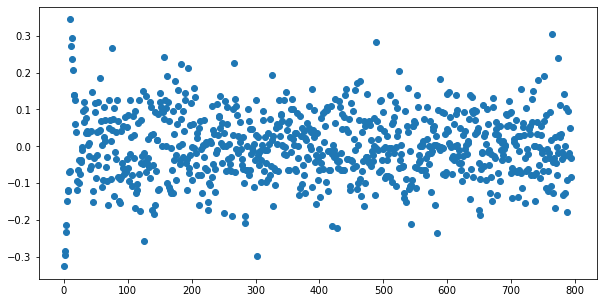

In [31]:
coefs = model[1].coef_[0]
plt.scatter(x=np.arange(len(coefs)),y=coefs)
plt.show()

In [32]:
model.fit(X, y.values.ravel())
confidences = model.decision_function(X)

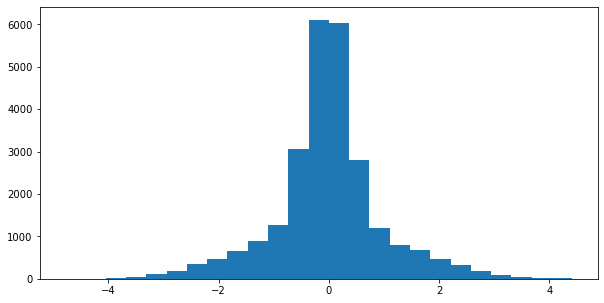

In [33]:
plt.hist(confidences, bins=25)
plt.show()

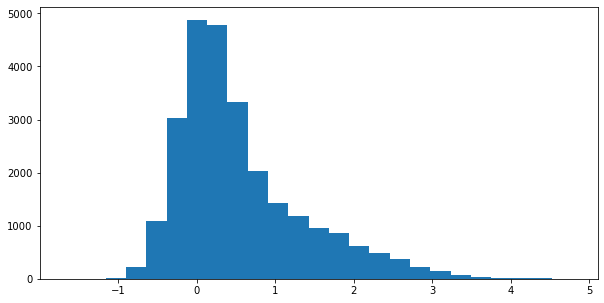

In [34]:
plt.hist(confidences * (2 * y.to_numpy().ravel() - 1), bins=25)
plt.show()

In [35]:
np.min(confidences * (2 * y.to_numpy().ravel() - 1))

-1.6749158517683027